In [1]:
from astropy.io import fits
import pandas as pd
from astropy.coordinates import SkyCoord
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster.vq import vq, kmeans
import scipy
from astroquery.gaia import Gaia
import os

import match

Text(0.5, 1.0, 'DES and Gaia Match Completeness (i-band)')

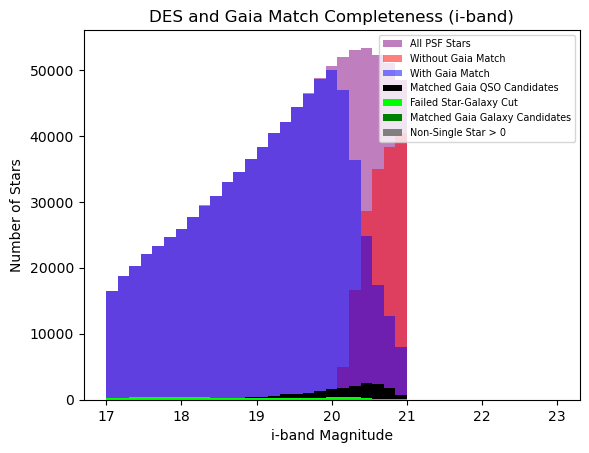

In [2]:
RESULTS_FILEPATH = "../results/"
RESULTS_FILEPATH_BAND = "../results/iband/"
BAND = 'i'
master_comb_df = pd.read_csv(RESULTS_FILEPATH_BAND + "DES_MATCH_BANDi.csv")
match.plot_match_completeness(master_comb_df, fold = RESULTS_FILEPATH_BAND, BAND = BAND, bounds = [17, 23])
plt.title("DES and Gaia Match Completeness (i-band)")

In [3]:
from astropy.io.votable import from_table, writeto
from astropy.table import Table

# Select the columns for Gaia RA and Dec
gaia_coords_df = master_comb_df[['gaia_ra', 'gaia_dec']]

# Convert the DataFrame to an Astropy Table
gaia_coords_table = Table.from_pandas(gaia_coords_df)

# Convert the Table to a VOTable
votable = from_table(gaia_coords_table)

# Save the VOTable as an XML file
votable_filepath = "gaia_coords_of_des.xml"
writeto(votable, votable_filepath)

print(f"VOTable saved to {votable_filepath}")

VOTable saved to gaia_coords_of_des.xml


In [4]:
# In the end, this was the query
# SELECT gaia.ra, gaia.dec, des.*
# FROM user_sagarwal.table1 AS des
# JOIN gaiadr3.gaia_source AS gaia ON 
# DISTANCE(des.gaia_ra, des.gaia_dec, gaia.ra, gaia.dec) < 0.00028

from astropy.io.votable import parse

# Parse the VOTable file
votable = parse("gaia_server_des_match.vot")

# Convert the first table in the VOTable to an Astropy Table
table = votable.get_first_table().to_table()

# Convert the Astropy Table to a pandas DataFrame
gaia_server_des_match_df = table.to_pandas()

print(gaia_server_des_match_df.head())

           ra        dec  astrometric_excess_noise  phot_g_mean_mag  \
0  314.094061 -64.284224                  3.319962        21.174145   
1  314.223159 -64.456143                  0.000000        19.095055   
2  315.600549 -64.293845                  0.097784        18.738873   
3  315.453591 -64.642682                  0.000000        18.637028   
4  315.074415 -61.354800                  0.000000        18.580177   

   phot_bp_mean_mag  phot_rp_mean_mag  des_oid     gaia_ra   gaia_dec  
0         20.634293         19.887693        1  314.094061 -64.284224  
1         20.296333         18.038639        2  314.223159 -64.456143  
2         20.060926         17.600863        3  315.600549 -64.293845  
3         19.343134         17.812775        4  315.453591 -64.642682  
4         19.162750         17.960045        5  315.074415 -61.354800  


In [5]:
des = gaia_server_des_match_df
des_merged = des.merge(master_comb_df, left_on=['ra', 'dec'], right_on=['gaia_ra', 'gaia_dec'], suffixes=('_des', '_master'))
#Separator: gaia_table["is_star"] = (np.log10(np.maximum(gaia_table['astrometric_excess_noise'], 1e-12)) < np.maximum((gaia_table['phot_g_mean_mag']-18.2)*.3+.2,.3))


(0.0, 2.0)

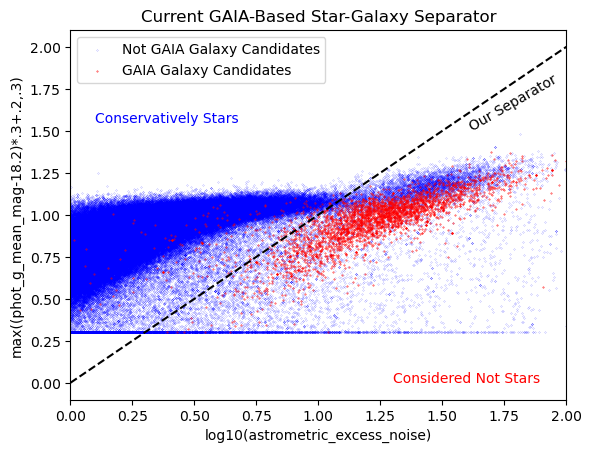

In [6]:
# Plot stars
stars = des_merged[des_merged['in_galaxy_candidates'] == False]
plt.scatter(np.log10(np.maximum(stars['astrometric_excess_noise'], 1e-12)), 
            np.maximum((stars['phot_g_mean_mag']-18.2)*.3+.2,.3), s = 0.01, c = 'blue', label='Not GAIA Galaxy Candidates')

# Plot galaxies
galaxies = des_merged[des_merged['in_galaxy_candidates'] == True]
plt.scatter(np.log10(np.maximum(galaxies['astrometric_excess_noise'], 1e-12)), 
            np.maximum((galaxies['phot_g_mean_mag']-18.2)*.3+.2,.3), s = 0.11, c = 'red', label='GAIA Galaxy Candidates')

# Add text annotations
plt.text(1.6, 1.5, "Our Separator", color='k', rotation=30)
plt.text(0.1, 1.55, "Conservatively Stars", color='blue')
plt.text(1.3, 0, "Considered Not Stars", color='red')

plt.legend()
plt.plot([0, 2], [0, 2], 'k--')
plt.title("Current GAIA-Based Star-Galaxy Separator")
plt.xlabel("log10(astrometric_excess_noise)")
plt.ylabel("max((phot_g_mean_mag-18.2)*.3+.2,.3)")
plt.xlim(0, 2)

In [28]:
vsaTab = pd.read_csv("vhs_random2.cat")

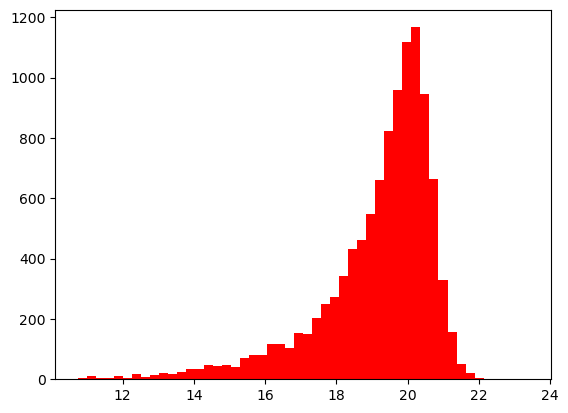

In [33]:
plt.hist(vsaTab['yapermag3'], bins = 50, color = 'r', label = 'VHS')
plt.show()

In [ ]:
# Print columns of hdul[1] file
file_path = "../data/psf_y3a1-v29.fits"
hdul = fits.open(file_path)
print(hdul[1].columns)


ColDefs(
    name = 'ra'; format = 'D'
    name = 'dec'; format = 'D'
    name = 'x'; format = 'D'
    name = 'y'; format = 'D'
    name = 'obs_e1'; format = 'D'
    name = 'obs_e2'; format = 'D'
    name = 'obs_T'; format = 'D'
    name = 'piff_e1'; format = 'D'
    name = 'piff_e2'; format = 'D'
    name = 'piff_T'; format = 'D'
    name = 'mag'; format = 'D'
    name = 'fov_x'; format = 'D'
    name = 'fov_y'; format = 'D'
    name = 'exp'; format = 'J'
    name = 'ccd'; format = 'I'
    name = 'band'; format = '1A'
    name = 'tiling'; format = 'I'
)


In [ ]:
def read_des_fits(file_path):
    # Read in the fits file and close it
    hdul = fits.open(file_path)
    
    # hdul[1].data is a numpy recarray. Get the ra, dec, mag and band columns   
    cols = ['ra', 'dec', 'mag', 'band']
    zidx = np.random.choice(np.where(hdul[1].data['band'] == 'z')[0], size = 1000, replace = False)
    data = {col: hdul[1].data[col][zidx] for col in cols}
    hdul.close()

    des = pd.DataFrame(data)
    

    # Combine ra and dec into a sky coord array
    des['coord'] = SkyCoord(ra=des['ra'], dec=des['dec'], unit = 'deg')
    return des

# Read in the DES data
file_path = "../data/psf_y3a1-v29.fits"
des = read_des_fits(file_path)


In [36]:
# Print columns of hdul[1] file
file_path = "../../psf_data/psf_y3a1-v29.fits"
hdul = fits.open(file_path)
print(hdul[1].columns)


ColDefs(
    name = 'ra'; format = 'D'
    name = 'dec'; format = 'D'
    name = 'x'; format = 'D'
    name = 'y'; format = 'D'
    name = 'obs_e1'; format = 'D'
    name = 'obs_e2'; format = 'D'
    name = 'obs_T'; format = 'D'
    name = 'piff_e1'; format = 'D'
    name = 'piff_e2'; format = 'D'
    name = 'piff_T'; format = 'D'
    name = 'mag'; format = 'D'
    name = 'fov_x'; format = 'D'
    name = 'fov_y'; format = 'D'
    name = 'exp'; format = 'J'
    name = 'ccd'; format = 'I'
    name = 'band'; format = '1A'
    name = 'tiling'; format = 'I'
)


In [40]:
np.unique(hdul[1].data['band'], return_counts=True)

(chararray(['Y', 'g', 'i', 'r', 'z'], dtype='<U1'),
 array([11019706,  7550610, 13434631, 10307271, 14395769]))

In [41]:
def read_des_fits(file_path):
    # Read in the fits file and close it
    hdul = fits.open(file_path)
    
    # hdul[1].data is a numpy recarray. Get the ra, dec, mag and band columns   
    cols = ['ra', 'dec', 'mag', 'band']
    zidx = np.random.choice(np.where(hdul[1].data['band'] == 'Y')[0], size = 10000, replace = False)
    data = {col: hdul[1].data[col][zidx] for col in cols}
    hdul.close()

    des = pd.DataFrame(data)
    

    # Combine ra and dec into a sky coord array
    des['coord'] = SkyCoord(ra=des['ra'], dec=des['dec'], unit = 'deg')
    return des

# Read in the DES data
file_path = "../../psf_data/psf_y3a1-v29.fits"
des = read_des_fits(file_path)


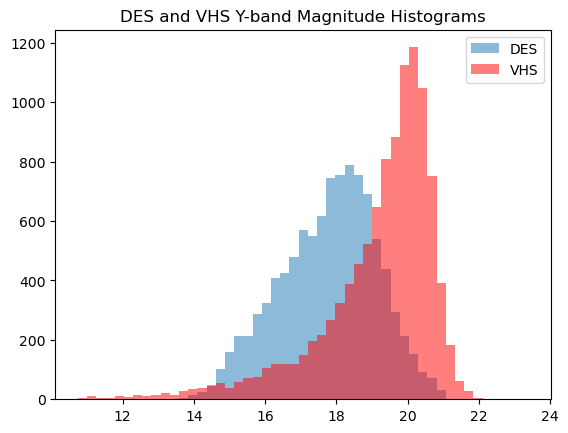

In [51]:
bins = np.linspace(min(des['mag'].min(), vsaTab['yapermag3'].min()), 
                   max(des['mag'].max(), vsaTab['yapermag3'].max()), 50)

plt.hist(des['mag'], bins=bins, alpha=0.5, label='DES')
plt.hist(vsaTab['yapermag3'], bins=bins, color='r', alpha=0.5, label='VHS')
plt.title("DES and VHS Y-band Magnitude Histograms")
plt.legend()
plt.show()

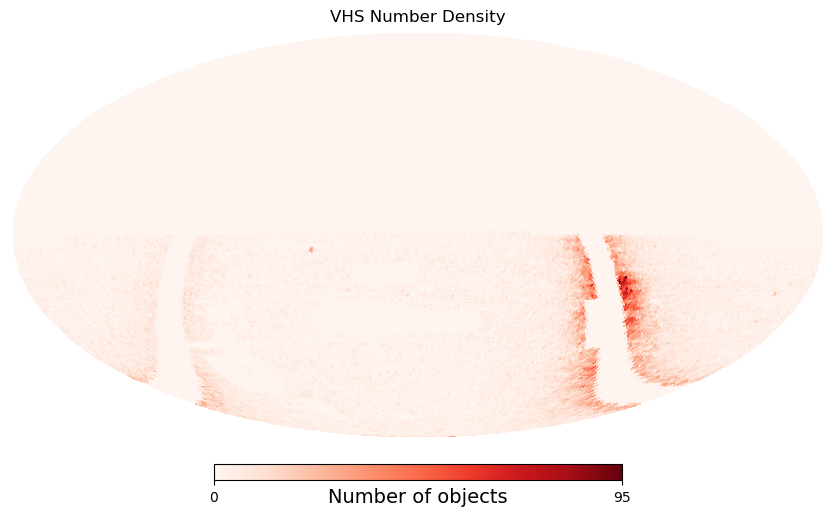

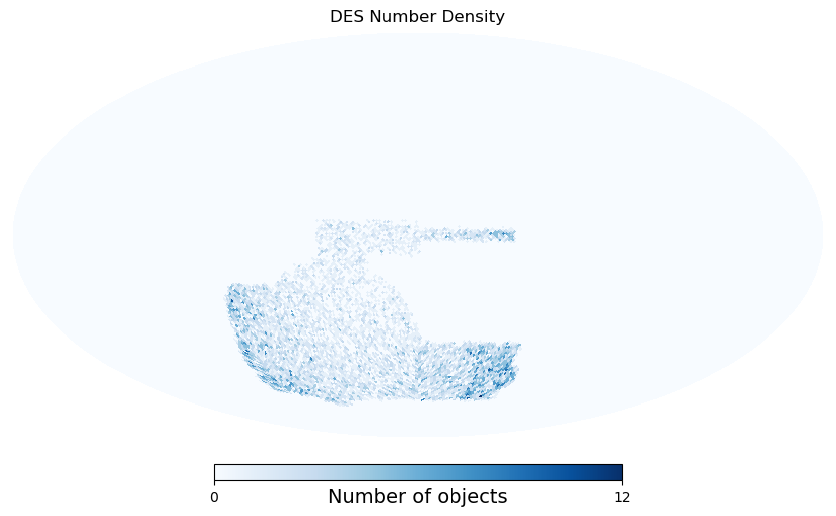

In [50]:
import healpy as hp

# Define the resolution of the HEALPix map
nside = 64

# Convert VHS and DES coordinates to HEALPix pixel indices
des_coords = SkyCoord(ra=des['ra'], dec=des['dec'], unit='deg')
vhs_coords = SkyCoord(ra=vsaTab['ra2000'], dec=vsaTab['dec2000'], unit='deg')

vhs_pix = hp.ang2pix(nside, vhs_coords.ra.deg, vhs_coords.dec.deg, lonlat=True)
des_pix = hp.ang2pix(nside, des_coords.ra.deg, des_coords.dec.deg, lonlat=True)

# Create HEALPix maps for VHS and DES
vhs_map = np.bincount(vhs_pix, minlength=hp.nside2npix(nside))
des_map = np.bincount(des_pix, minlength=hp.nside2npix(nside))

# Plot the number density maps
hp.mollview(vhs_map, title="VHS Number Density", unit="Number of objects", cmap='Reds')
hp.mollview(des_map, title="DES Number Density", unit="Number of objects", cmap='Blues')
plt.show()
